In [1]:
!pip install geopandas shapely fiona pyproj rtree

In [2]:
import fiona 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Getting Data

### Fire Perimeters

In [3]:
! wget https://frap.fire.ca.gov/media/3ufh3ajg/fire21_1.zip -O fire_perims.zip -nc 

File 'fire_perims.zip' already there; not retrieving.


In [4]:
! unzip -n fire_perims.zip 

Archive:  fire_perims.zip


In [5]:
! ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
gdb_file = 'fire21_1.gdb'

# Get all the layers from the .gdb file 
layers = fiona.listlayers(gdb_file)

for layer in layers:
  if layer == 'firep21_1': # there are 3 files in gdb, we only need one
    print(f'found file: {layer}')
    fires = gpd.read_file(gdb_file,layer=layer)

found file: firep21_1


In [7]:
fires.shape

(21686, 18)

<AxesSubplot: >

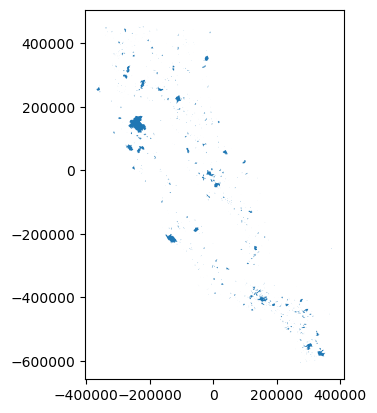

In [8]:
# there are 20k fires in the data set, lets randomly plot 1000 of them
fires.sample(1000).plot()

In [9]:
fires.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry
0,2020,CA,CDF,NEU,NELSON,00013212,2020-06-18T00:00:00+00:00,2020-06-23T00:00:00+00:00,11.0,,110.0,109.602280,1.0,1.0,None,3252.523280,4.435447e+05,"MULTIPOLYGON (((-116841.251 97942.565, -116836..."
1,2020,CA,CDF,NEU,AMORUSO,00011799,2020-06-01T00:00:00+00:00,2020-06-04T00:00:00+00:00,2.0,,670.0,685.585022,1.0,1.0,None,9653.760308,2.774464e+06,"MULTIPOLYGON (((-117328.400 90212.407, -117321..."
2,2020,CA,CDF,NEU,ATHENS,00018493,2020-08-10T00:00:00+00:00,2020-03-01T00:00:00+00:00,14.0,,26.0,27.300480,1.0,1.0,None,1649.643235,1.104811e+05,"MULTIPOLYGON (((-115605.059 92988.787, -115585..."
3,2020,CA,CDF,NEU,FLEMING,00007619,2020-03-31T00:00:00+00:00,2020-04-01T00:00:00+00:00,9.0,,13.0,12.931545,1.0,1.0,None,1577.155857,5.233211e+04,"MULTIPOLYGON (((-110213.270 105975.579, -11020..."
4,2020,CA,CDF,NEU,MELANESE,00008471,2020-04-14T00:00:00+00:00,2020-04-19T00:00:00+00:00,18.0,,10.3,10.315964,1.0,1.0,None,1035.787625,4.174722e+04,"MULTIPOLYGON (((-111793.600 164243.615, -11177..."


In [10]:
fires.dtypes

YEAR_             object
STATE             object
AGENCY            object
UNIT_ID           object
FIRE_NAME         object
INC_NUM           object
ALARM_DATE        object
CONT_DATE         object
CAUSE            float64
COMMENTS          object
REPORT_AC        float64
GIS_ACRES        float64
C_METHOD         float64
OBJECTIVE        float64
FIRE_NUM          object
Shape_Length     float64
Shape_Area       float64
geometry        geometry
dtype: object

In [11]:
# lets drop some variables that we will not be using 
print(fires.shape[1])
fires.drop(['STATE', 'COMMENTS', 'C_METHOD', 'OBJECTIVE'], axis=1, inplace=True)
print(fires.shape[1])

18
14


In [12]:
# some mumbo jumbo with the dates 
fires['ALARM_DATE'] = fires.ALARM_DATE.str.slice(0,10)
fires['CONT_DATE'] = fires.CONT_DATE.str.slice(0,10)
fires

,YEAR_,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,FIRE_NUM,Shape_Length,Shape_Area,geometry
0,2020,CDF,NEU,NELSON,00013212,2020-06-18,2020-06-23,11.0,110.0,109.602280,None,3.252523e+03,4.435447e+05,"MULTIPOLYGON (((-116841.251 97942.565, -116836..."
1,2020,CDF,NEU,AMORUSO,00011799,2020-06-01,2020-06-04,2.0,670.0,685.585022,None,9.653760e+03,2.774464e+06,"MULTIPOLYGON (((-117328.400 90212.407, -117321..."
2,2020,CDF,NEU,ATHENS,00018493,2020-08-10,2020-03-01,14.0,26.0,27.300480,None,1.649643e+03,1.104811e+05,"MULTIPOLYGON (((-115605.059 92988.787, -115585..."
3,2020,CDF,NEU,FLEMING,00007619,2020-03-31,2020-04-01,9.0,13.0,12.931545,None,1.577156e+03,5.233211e+04,"MULTIPOLYGON (((-110213.270 105975.579, -11020..."
4,2020,CDF,NEU,MELANESE,00008471,2020-04-14,2020-04-19,18.0,10.3,10.315964,None,1.035788e+03,4.174722e+04,"MULTIPOLYGON (((-111793.600 164243.615, -11177..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21681,2021,USF,SQF,BOYDEN 1,00000401,2021-03-03,2021-03-18,5.0,15.0,14.573442,None,9.276290e+02,5.897663e+04,"MULTIPOLYGON (((105451.745 -132832.621, 105410..."
21682,2021,USF,INF,GLACIER NORTH,00001732,2021-07-15,2021-08-20,1.0,37.0,37.255802,None,2.334983e+03,1.507689e+05,"MULTIPOLYGON (((139955.910 -95054.743, 139970...."
21683,2021,CCO,KRN,Backus 2,02118345,2021-04-25,2021-04-25,14.0,4.0,2.897352,None,6.368478e+02,1.172517e+04,"MULTIPOLYGON (((164896.149 -338556.435, 164893..."
21684,2021,CDF,BTU,DIXIE,00009205,2021-07-14,2021-10-25,11.0,963309.0,963405.437500,None,1.533820e+06,3.898763e+09,"MULTIPOLYGON (((-92538.590 256767.148, -92537...."


In [13]:
# calculate the number of where date is missing
print('number of missing records for alarm date:', fires.ALARM_DATE.isnull().sum())
print('number of missing records for containment date:', fires.CONT_DATE.isnull().sum()) 

number of missing records for alarm date: 5357
number of missing records for containment date: 12666


In [14]:
# convert variables to datetime
fires['ALARM_DATE'] = pd.to_datetime(fires.ALARM_DATE, errors='coerce')
fires['CONT_DATE'] = pd.to_datetime(fires.CONT_DATE, errors='coerce')

In [15]:
# calculate new variable duration 
#fires['dur_days'] = (fires.CONT_DATE - fires.ALARM_DATE).dt.days
fires['dur_days'] = (fires.CONT_DATE - fires.ALARM_DATE).astype('timedelta64[D]')

print('Values where alarm date is before containment date:', fires.loc[fires.dur_days<0].shape[0])

Values where alarm date is before containment date: 32


In [16]:
fires.dur_days.isnull().sum()

12678

In [17]:
# drop where we have missing duration
print(fires.shape)
fires = fires.loc[fires.dur_days>0,]
print(fires.shape)

(21686, 15)
(5250, 15)


### California Counties

In [18]:
ca_counties = gpd.read_file('https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson')
print(ca_counties.shape)
ca_counties.head()

(58, 5)


,name,cartodb_id,created_at,updated_at,geometry
0,Alameda,1,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"MULTIPOLYGON (((-122.31293 37.89733, -122.2884..."
1,Alpine,2,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.07239 38.70277, -119.96495 38.7..."
2,Amador,3,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.02726 38.48925, -121.02741 38.5..."
3,Butte,4,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-121.87925 39.30361, -121.90831 39.3..."
4,Calaveras,5,2015-07-04 21:04:58+00:00,2015-07-04 21:04:58+00:00,"POLYGON ((-120.87605 38.02889, -120.91875 38.0..."


### Projections! 

In [19]:
# check 
print(fires.crs)
print(ca_counties.crs)

epsg:3310
epsg:4326


In [20]:
# let's convert both of those to epsg:3857
# this will take a while - lots of calculations
fires = fires.to_crs('epsg:3857')
ca_counties = ca_counties.to_crs('epsg:3857')

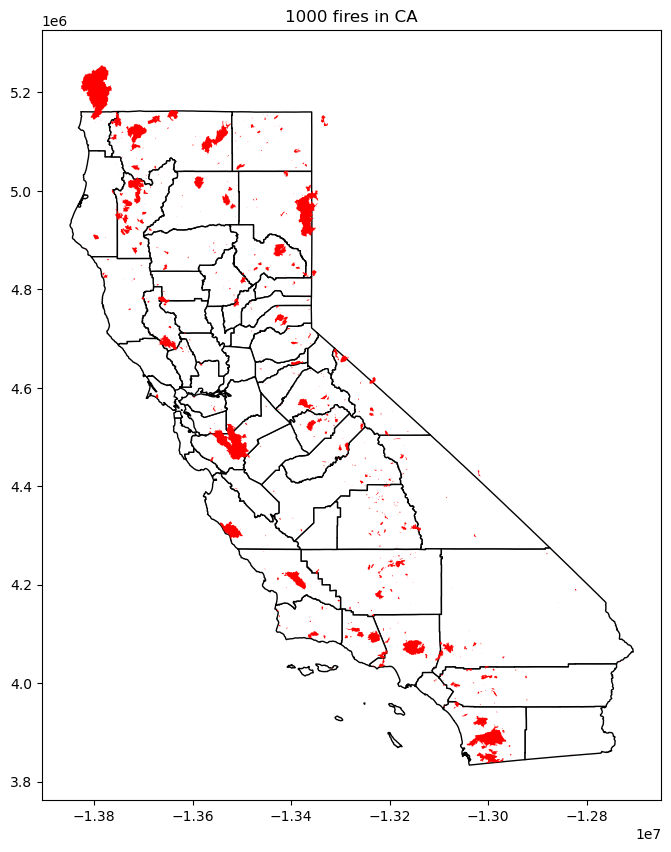

In [21]:
# plot fires on CA
fig,ax = plt.subplots(figsize=(10,10))

ca_counties.plot(ax=ax, facecolor='w', ec='k');
fires.sample(1000).plot(fc='r', ax=ax);

plt.title('1000 fires in CA');

In [22]:
# THIS PART OF CODE IS OPENING A FILE VIA OGR - SKIP
# SOME LABELS ARE NOT READ BY GEOPANDAS 
# from osgeo import ogr

# driver = ogr.GetDriverByName("OpenFileGDB")
# ds = driver.Open("fire21_1.gdb", 0)
# f = ds.GetLayer("firep21_1")
# print(type(f))

## Measures of Location and Variation

In [23]:
print('mean', fires.GIS_ACRES.mean())
print('median', fires.GIS_ACRES.median())
print('std', fires.GIS_ACRES.std())

mean 4342.1049991099635
median 135.8330841064453
std 28498.104881528623


## Visualizing Data

### Histograms

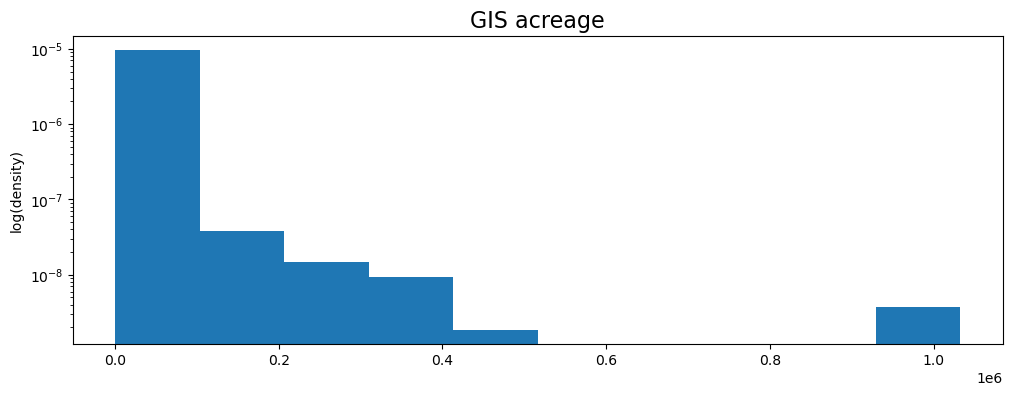

In [24]:
fig, ax = plt.subplots(figsize=(12,4))

fires.GIS_ACRES.plot(density=True, logy=True, kind='hist', ax=ax);

# changing title and labels
ax.set_title('GIS acreage', fontsize=16);
ax.set_ylabel('log(density)');


In [25]:
# create histograms for all numeric variables 
num_vars = fires.select_dtypes(include=np.number).columns.tolist()
num_vars

['CAUSE', 'REPORT_AC', 'GIS_ACRES', 'Shape_Length', 'Shape_Area', 'dur_days']

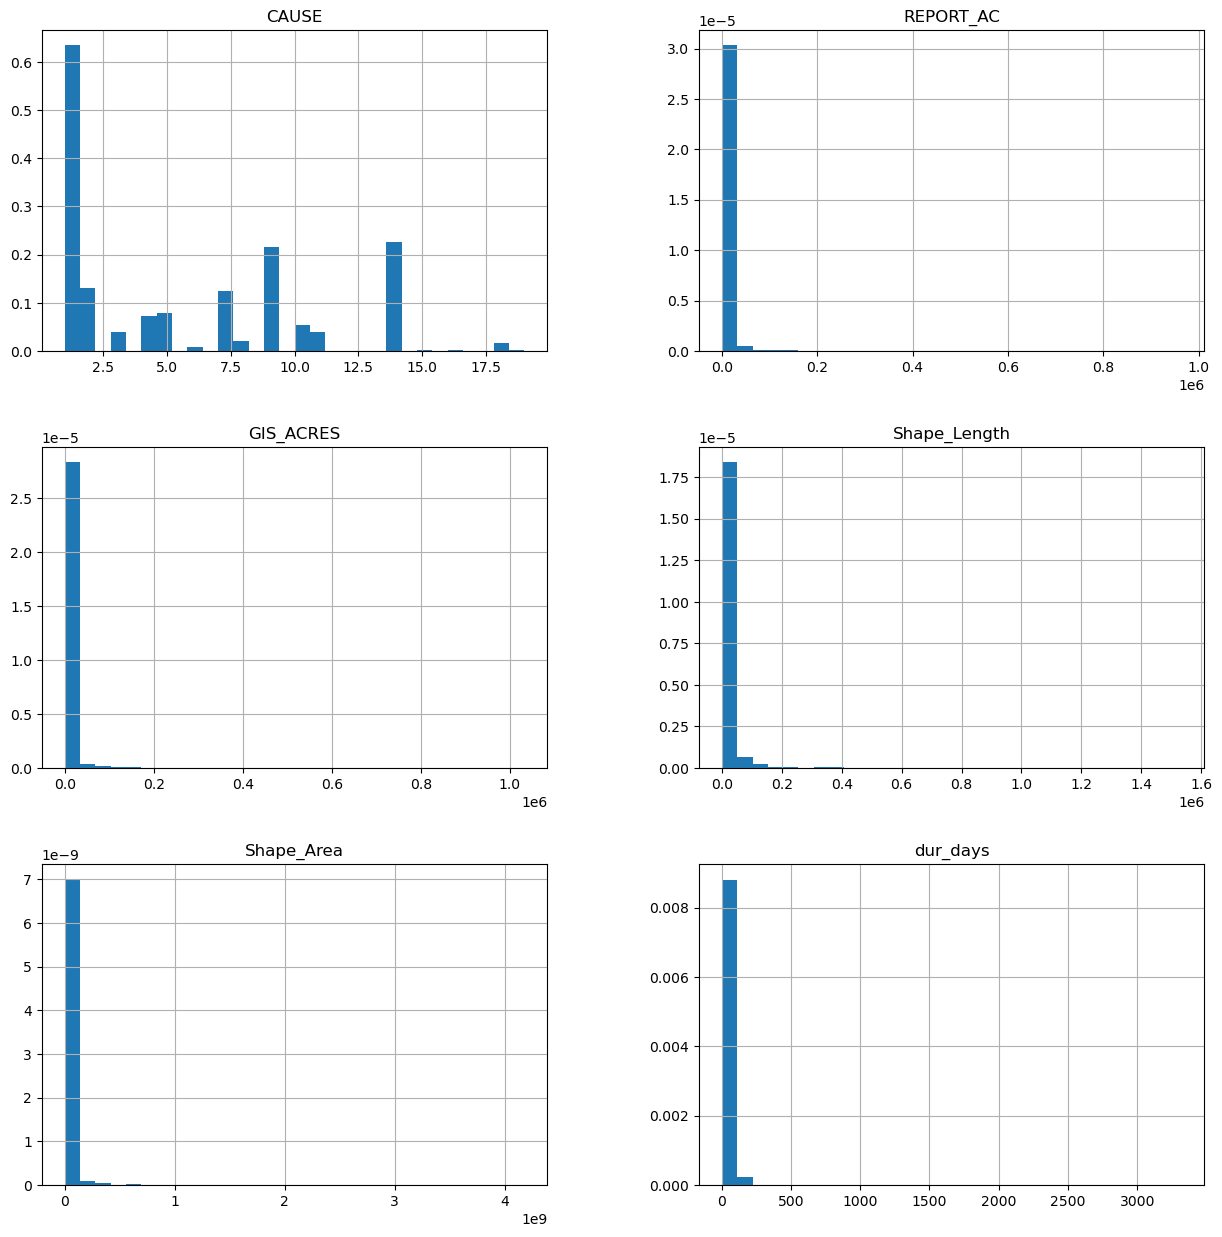

In [26]:
fires[num_vars].hist(density=True, bins=30, figsize=(15,15));

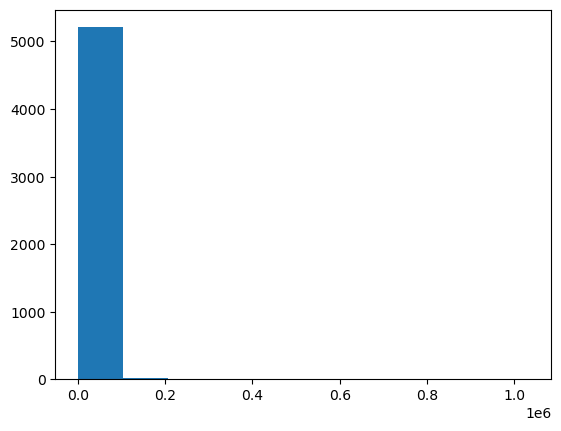

In [27]:
# we can also call histogram from matplotlib interface 
plt.hist(fires.GIS_ACRES);

## Asking interesting questions about data 

1. What is the average size of wildfires in CA
2. Does average size of fires increase over time? 
3. How many fires do we have per year? 
4. Does the number of fires increase over time? 
5. How does average fire duration change? 

In [28]:
# calculating average size of fires in CA 
fires.area.mean() # this is in square meters: 28,624,990

28624990.01473271

In [29]:
# convert YEAR_ to int 
fires.YEAR_ = fires.YEAR_.astype(int)
fires.dtypes

YEAR_                    int32
AGENCY                  object
UNIT_ID                 object
FIRE_NAME               object
INC_NUM                 object
ALARM_DATE      datetime64[ns]
CONT_DATE       datetime64[ns]
CAUSE                  float64
REPORT_AC              float64
GIS_ACRES              float64
FIRE_NUM                object
Shape_Length           float64
Shape_Area             float64
geometry              geometry
dur_days               float64
dtype: object

### Grouping variables and summarizing

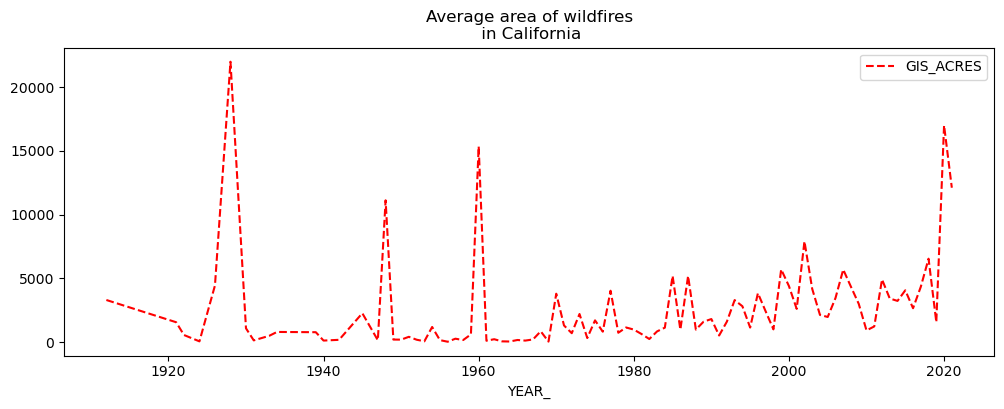

In [30]:
# only use variables that you will be calculating on 
avg_acres_by_year = fires[['YEAR_', 'GIS_ACRES']].groupby('YEAR_')["GIS_ACRES"].mean().reset_index()

avg_acres_by_year.set_index('YEAR_', inplace=True)

avg_acres_by_year.plot(figsize=(12,4), title='Average area of wildfires\n in California', color='r', linestyle='dashed');

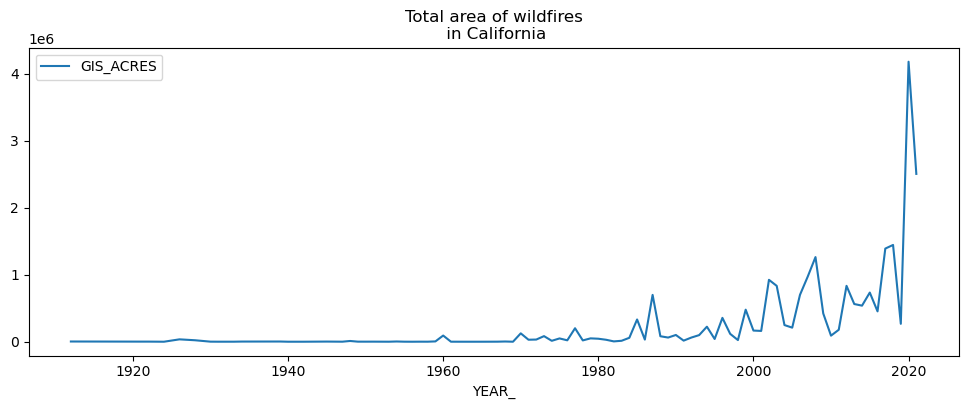

In [31]:
# only use variables that you will be calculating on 
total_acres_by_year = fires[['YEAR_', 'GIS_ACRES']].groupby('YEAR_')["GIS_ACRES"].sum().reset_index()

total_acres_by_year.set_index('YEAR_', inplace=True)

total_acres_by_year.plot(figsize=(12,4), title='Total area of wildfires\n in California');

In [32]:
print(fires.shape[0]) # number of records
print(fires.INC_NUM.count()) # number of fire_id 

5250
5083


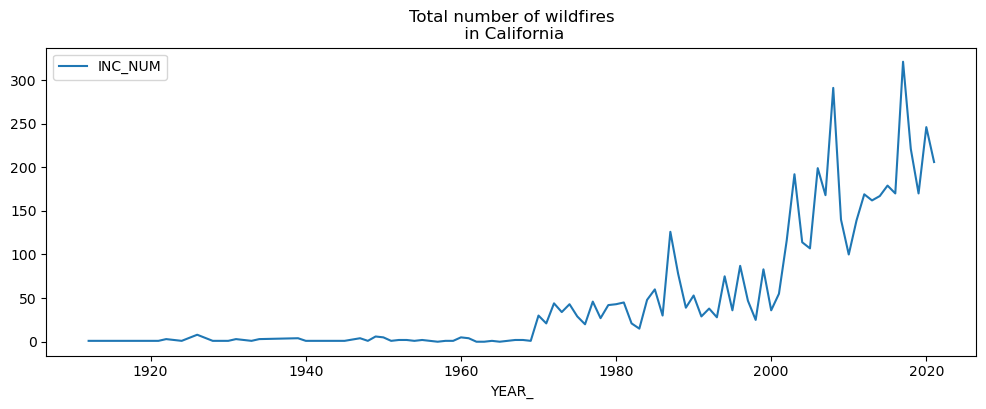

In [33]:
# calculate number of fires per year 
fires_per_year = fires[['YEAR_', 'INC_NUM']].groupby('YEAR_')["INC_NUM"].count().reset_index()

fires_per_year.set_index('YEAR_', inplace=True)

fires_per_year.plot(figsize=(12,4), title='Total number of wildfires\n in California');

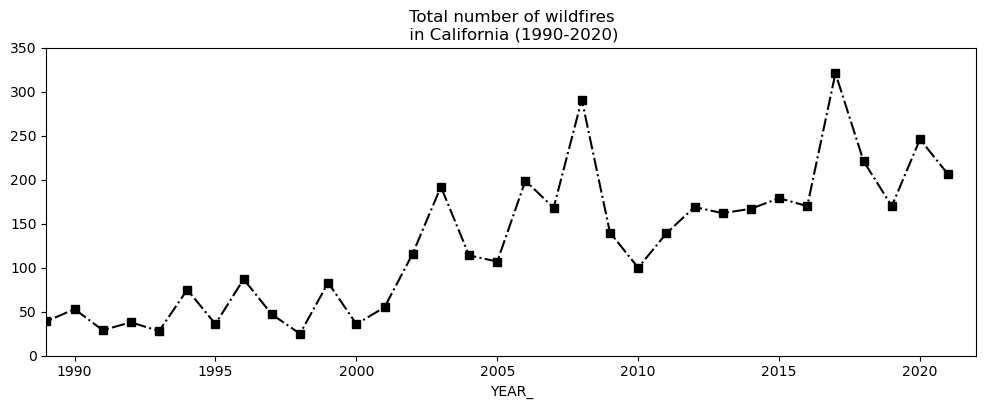

In [34]:
# zoom into specific years and change range on y-axis, remove legend label, change linestyle and marker style
fires_per_year.plot(figsize=(12,4), title='Total number of wildfires\n in California (1990-2020)', ylim=(0,350), xlim=(1989,2022), legend=False, color='k', marker='s', linestyle='-.');

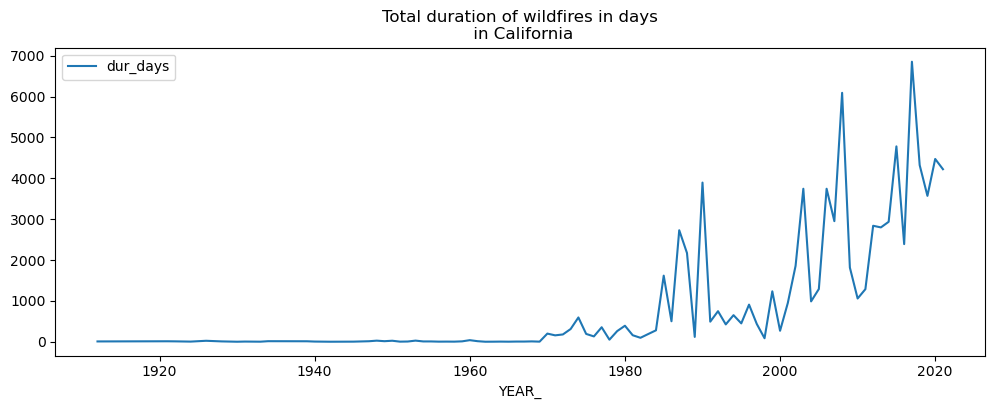

In [35]:
# total duration of fires per year
dur_per_year = fires[['YEAR_', 'dur_days']].groupby('YEAR_')["dur_days"].sum().reset_index()

dur_per_year.set_index('YEAR_', inplace=True)

dur_per_year.plot(figsize=(12,4), title='Total duration of wildfires in days\n in California');

In [36]:
# get temperature 
ca_temps = pd.read_csv('https://www.ncei.noaa.gov/cag/statewide/time-series/4-tavg-12-12-1910-2022.csv?base_prd=true&begbaseyear=1901&endbaseyear=2000', skiprows=5, header=None, dtype={0:'str'}, nrows=100) # use this line if following lab instructions
#ca_temps = pd.read_csv('https://raw.githubusercontent.com/barguzin/ucsb_geog172/main/data/ca_avg_temps.csv', skiprows=5, header=None, dtype={0:'str'}, nrows=100)
print(ca_temps.shape)
ca_temps.head()

(100, 3)


,0,1,2
0,191012,57.7,0.3
1,191112,55.4,-2.0
2,191212,55.5,-1.9
3,191312,56.4,-1.0
4,191412,57.4,0.0


In [37]:
ca_temps.columns = ['date_year', 'temp', 'anomaly']

In [38]:
# prep year 
# convert to 
ca_temps.date_year = ca_temps.date_year.str.slice(0,4)

ca_temps.date_year = ca_temps.date_year.astype(int)

ca_temps.set_index('date_year', inplace=True)

ca_temps.tail()

,temp,anomaly
date_year,,
2005,58.6,1.2
2006,58.6,1.2
2007,58.9,1.5
2008,58.9,1.5
2009,58.8,1.4


In [39]:
print(ca_temps.index.dtype)
print(dur_per_year.index.dtype)

int64
int64


Text(0.5, 1.0, 'Total duration of wildfires in CA')

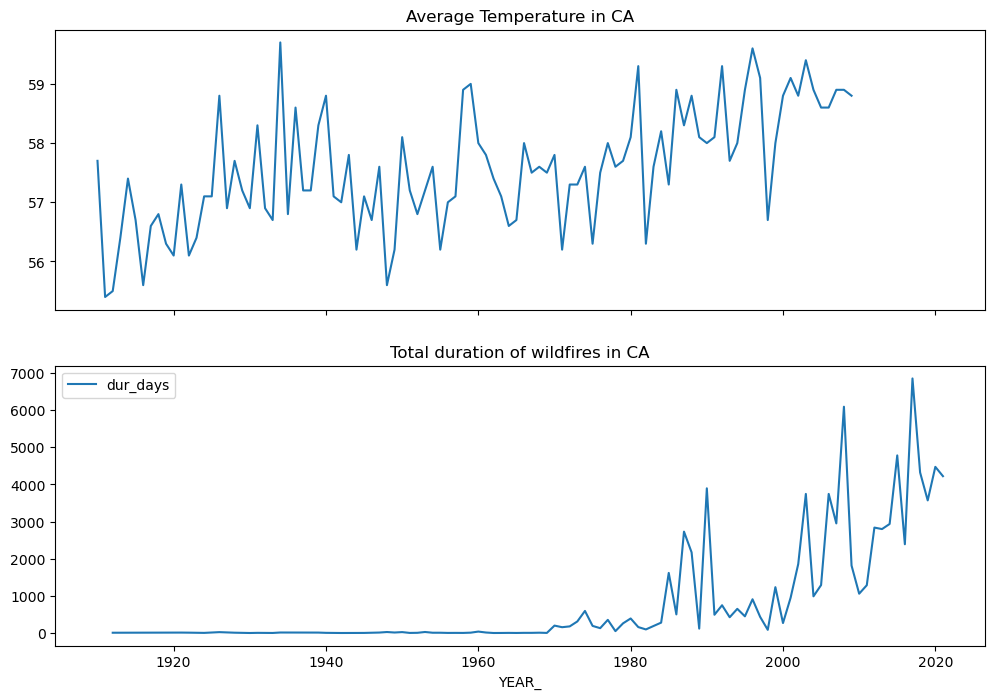

In [40]:
# plot total duration of wildfires and average temps on two subplots 

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8), sharex=True)

ca_temps.temp.plot(ax=ax1)
ax1.set_title('Average Temperature in CA')

dur_per_year.plot(ax=ax2)
ax2.set_title('Total duration of wildfires in CA')

#### There is a problem with index alignment, we need to merge dataframes! 

Text(0.5, 1.0, 'Total duration of wildfires in CA')

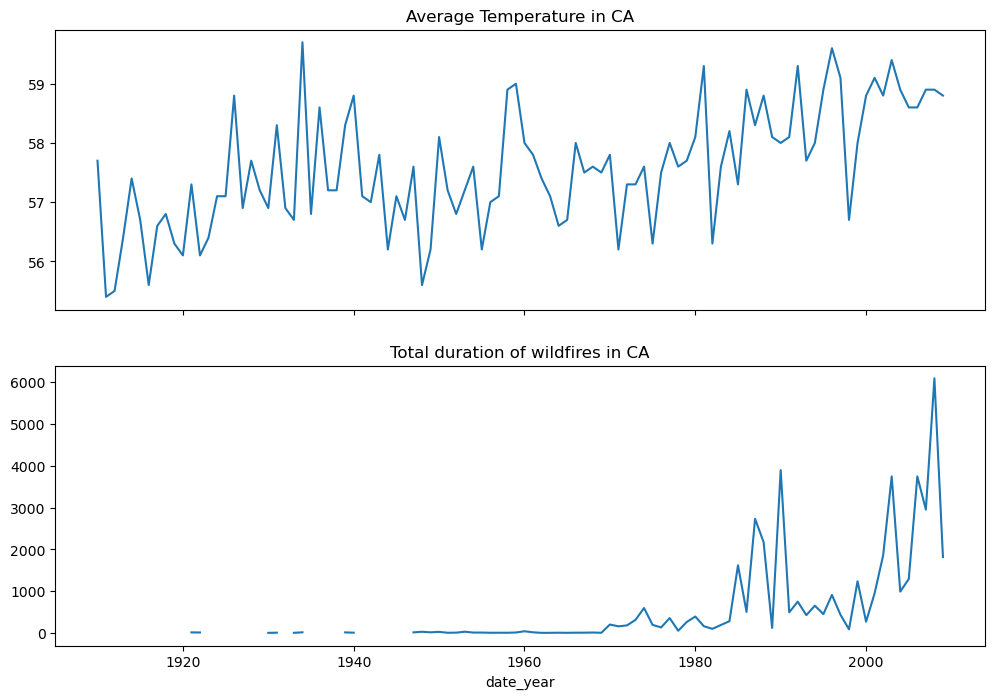

In [41]:
merged = ca_temps.join(dur_per_year)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8), sharex=True)

merged.temp.plot(ax=ax1)
ax1.set_title('Average Temperature in CA')

merged.dur_days.plot(ax=ax2)
ax2.set_title('Total duration of wildfires in CA')

## Spatial join and some summary statistics 

Let's imagine you work at the county GIS Department. You are tasked to describe the wildfire situation in that county. We need to be able to subset our data set by county. For that we need to run spatial join. 

In [42]:
# join fires to counties 
print(fires.shape) # total number of fires before join 
sj = fires.sjoin(ca_counties[['name', 'geometry']], how='left') # only keep name and geometry other variables are not required
print(sj.shape) # total number of fires after join - notice some were duplicated because some fires stretch several couinties! 

(5250, 15)


(5626, 17)


In [43]:
sj.head()

,YEAR_,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,REPORT_AC,GIS_ACRES,FIRE_NUM,Shape_Length,Shape_Area,geometry,dur_days,index_right,name
0,2020,CDF,NEU,NELSON,00013212,2020-06-18,2020-06-23,11.0,110.0,109.602280,None,3252.523280,4.435447e+05,"MULTIPOLYGON (((-13508442.691 4705925.734, -13...",5.0,50.0,Placer
1,2020,CDF,NEU,AMORUSO,00011799,2020-06-01,2020-06-04,2.0,670.0,685.585022,None,9653.760308,2.774464e+06,"MULTIPOLYGON (((-13508926.724 4695976.079, -13...",3.0,50.0,Placer
3,2020,CDF,NEU,FLEMING,00007619,2020-03-31,2020-04-01,9.0,13.0,12.931545,None,1577.155857,5.233211e+04,"MULTIPOLYGON (((-13500067.530 4716384.517, -13...",1.0,50.0,Placer
4,2020,CDF,NEU,MELANESE,00008471,2020-04-14,2020-04-19,18.0,10.3,10.315964,None,1035.787625,4.174722e+04,"MULTIPOLYGON (((-13503127.248 4791692.208, -13...",5.0,42.0,Yuba
6,2020,DOD,BEA,VALLEY,00015865,2020-07-15,2020-07-16,14.0,377.0,376.910400,None,7596.639583,1.525302e+06,"MULTIPOLYGON (((-13511624.292 4738027.675, -13...",1.0,42.0,Yuba


In [44]:
fires_by_county = sj.groupby(['name'])['INC_NUM'].size().reset_index()

print(fires_by_county.shape)
fires_by_county.sort_values(by='INC_NUM', inplace=True)
print('top 10 counties with most fires')
fires_by_county[::-1][:10]

(57, 2)
top 10 counties with most fires


,name,INC_NUM
52,Tulare,360
45,Siskiyou,307
53,Tuolumne,276
14,Kern,274
24,Modoc,254
9,Fresno,251
51,Trinity,250
36,San Diego,246
35,San Bernardino,235
32,Riverside,216


In [45]:
print('bottom 10 counties with most fires')
fires_by_county[:10]

bottom 10 counties with most fires


,name,INC_NUM
33,Sacramento,2
39,San Mateo,3
49,Sutter,4
15,Kings,5
20,Marin,9
0,Alameda,10
37,San Joaquin,11
23,Merced,12
6,Contra Costa,13
12,Imperial,14


#### Optional: plot number of fires in top 10 counties in California over time

In [46]:
from google.colab import drive
import os

# if you want to save file to your google drive 
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [60]:
# save to Drive
fires.to_file('/content/drive/MyDrive/geog172/fires.geojson')

In [61]:
# we can also save it to the content of the GC session and then right click and download to local computer 
fires.to_file('fires.geojson')